<a href="https://colab.research.google.com/github/Jarvis-X/Swarms-Course-Projects/blob/main/SawStable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable_baselines3
!pip install gym[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 170 kB 33.1 MB/s 
     |████████████████████████████████| 1.5 MB 66.3 MB/s 
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616823 sha256=be4568f1cc318055f8537d158bd5ecf7913d06114c6123cff1368ff96c539edd
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 20.3 MB/s 
     |████████████████████████████████| 964 kB 63.7 MB/s 
     |████████████████████████████████| 1.6 MB 63.6 MB/s 
     |████████████████████████████████| 1.2 MB 64.9 MB/s 
     |████████████████████████████████| 374 kB 67.6 MB/s 
     |████████████████████████████████| 207 kB 76.0 MB/s 
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build box2d-py mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-0mh4kb7k/mujoco-py_4d3d095844c1496c956e38cfb0e470a3/setup.py'"'"'; __file__='"'"'/tmp/pip-install-0mh4kb7k/mujoco-py_4d3d095844c1496c956e38cfb0e470a3/

In [ ]:
import gym
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

In [ ]:
from IPython.utils import tempdir
import gym, torch, numpy as np, torch.nn as nn
from gym import spaces
import numpy as np
class SimulateSawEnv(gym.Env):
  

    def __init__(self, render_mode=None, dt = .05):
        
        self.mu_a = 0.5 # amonton's law
        self.mu_c = 0.5 # coulomb's law
        self.num_steps = 0
        # length of the saw
        self.L = 0.8
        # state vector
        self.state = [self.L/10, 0, 0, 0] # d, theta, dd, dtheta
        # mass of the saw-drone system
        self.m = 0.5
        # moment of inertia with centered inertia = 0.05
        self.I = 0.05 + self.m*(self.state[0]-self.L/2)**2
        # Do we want cvxopt?
        self.en_cvx = False
        # Do we want constains?
        self.en_constrain = True
        # simulation time
        self.time_out = 20
        # number of motors
        self.n = 4
        # position of the thrusters from the left side of the drone
        self.p = np.array([[self.L/8, 0], [3*self.L/8, 0], [5*self.L/8, 0], [7*self.L/8, 0]]).T
        # position of the contact point on the drone
        self.p_c = np.array([self.state[0], 0])
        # tilting angles of the propellers
        self.alpha = np.array([-30, 30, -30, 30])*np.pi/180.0
        # gravity acceleration
        self.g = 9.8
        # time step
        self.dt = dt#0.005
        # max force of a propeller
        self.fM = 20.0
        # minimum force of a propeller
        self.fm = 0

        # A-matrix of the quadrotor
        # force part remains unchanged, good thing everything is local now
        self.Af = np.zeros([2, self.n]);
        # torque should change based on d
        self.Atau = np.zeros([1, self.n]);
        self.R = np.zeros([2, 2*self.n]);
        for i in range(self.n):
            self.R[:, 2*i:2*i+2] = [[np.cos(self.alpha[i]), -np.sin(self.alpha[i])],
                            [np.sin(self.alpha[i]), np.cos(self.alpha[i])]]
            self.Af[:,i] = self.R[:, 2*i:2*i+2].dot(np.array([0, 1]))
            self.Atau[:,i] = np.cross(self.p[:,i]-self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        self.A = np.concatenate([self.Af, self.Atau], axis=0)

        self.action_space = spaces.Box(np.array([-1, -1]), np.array([1, 1]), shape=(2,), dtype=np.float32)
        self.observation_space = spaces.Box(np.array([0, -np.pi/2,-5,-5]), np.array([self.L, np.pi/2,5,5]), shape=(4,), dtype=np.float32)
        

        #Temporary goal state
        self.goal_d = self.L*.9

        
    def _get_obs(self):
        return np.array(self.state, dtype=np.float32)
    
    def _get_info(self):
        return {}#self.state[0] - self.goal_d#{"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}
    
    def reset(self, seed=None, options=None):
        #self.close()
        # We need the following line to seed self.np_random
        #super().reset()#seed=seed)
        self.state = [self.L/10, 0, 0, 0] # d, theta, dd, dtheta
        self.I = 0.05 + self.m*(self.state[0]-self.L/2)**2
        self.num_steps = 0
        self.p_c = np.array([self.state[0], 0])
        # tilting angles of the propellers
        self.alpha = np.array([-30, 30, -30, 30])*np.pi/180.0

        self.fM = 20.0
        # minimum force of a propeller
        self.fm = 0
        
        self.Af = np.zeros([2, self.n]);
        # torque should change based on d
        self.Atau = np.zeros([1, self.n]);
        self.R = np.zeros([2, 2*self.n]);
        for i in range(self.n):
            self.R[:, 2*i:2*i+2] = [[np.cos(self.alpha[i]), -np.sin(self.alpha[i])],
                            [np.sin(self.alpha[i]), np.cos(self.alpha[i])]]
            self.Af[:,i] = self.R[:, 2*i:2*i+2].dot(np.array([0, 1]))
            self.Atau[:,i] = np.cross(self.p[:,i]-self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        self.A = np.concatenate([self.Af, self.Atau], axis=0)

        observation = self._get_obs()
        info = self._get_info()


        return observation
    
    def step(self, action):
        f = self.ideal_controller(action[0]*20, action[1]*5)
        next_state = self.part_step(f)
        reward, terminated = self.evaluate(next_state)
        self.state = next_state
        info = self._get_info()
        self.num_steps += 1
        return self._get_obs(), reward, terminated, {"f":f}

    def evaluate(self, next_state):
        
        terminated = False
        reward = 0
        if self.num_steps > 350 or \
                next_state[2] > 4 or next_state[2] < -4 or \
                next_state[3] > 4 or next_state[3] < -4 or \
                next_state[0] < 0 or next_state[0] > self.L or abs(next_state[1]) >= np.pi/2:
            reward = -300 
            terminated = True
        elif next_state[0] >= self.goal_d and \
                abs(next_state[2]) < .05:
            reward = 6000 - self.num_steps * 10 #- (10*abs(next_state[2]))**2 - 10*abs(next_state[3])
            terminated = True
            if reward < 1000:
                reward = 1000
        else:
            reward = -5*(abs(next_state[0] - self.goal_d))**.5
            
        return reward, terminated

    def evaluate2(self, next_state):
        failure_val = -300
        failure_k = 5
        terminated = False
        reward = 0
        if self.num_steps > 350:
            reward = failure_val 
            terminated = True
        elif next_state[0] >= self.goal_d:
            if next_state[0] >= self.L:
                reward = 500 - (10*abs(next_state[2]))**2 - 10*abs(next_state[3])
                if reward < failure_val:
                    reward = failure_val
                terminated = True
            else:
                if  abs(next_state[2]) < .05 and \
                    abs(next_state[3]) < .05:
                    reward = 6000 - self.num_steps * 10 - (10*abs(next_state[2]))**2 - 10*abs(next_state[3])
                    terminated = True
                    if reward < 1000:
                        reward = 1000
                else:
                    reward = -1*(failure_k*abs(next_state[0] - self.goal_d))**.5
                
        
        elif next_state[2] > 4 or next_state[2] < -4 or \
                next_state[3] > 4 or next_state[3] < -4:
            reward = failure_val 
            terminated = True

        elif next_state[0] < 0:
            reward = failure_val 
            terminated = True
            
        elif next_state[1] < -np.pi/2:
            reward = failure_val
            terminated = True
            
        elif next_state[1] >= np.pi/2:
            reward = failure_val 
            terminated = True
        else:
            reward = -1*(failure_k*abs(next_state[0] - self.goal_d))**.5
            
        return reward, terminated

    def ideal_controller(self, ddd, ddtheta):
        f = np.linalg.pinv(self.A).dot(np.array([-ddd*self.m, 0, ddtheta*self.I]))
        if self.en_constrain: 
            return self.clamp(f, self.fm, self.fM)
        else:
            return f
        return f
    
    # step function for the motion of the saw-drone
    def part_step(self, u):
        
        d, theta, dd, dtheta = self.state

        # change the torque part of the A matrix based on d
        self.p_c = np.array([d, 0])
        for i in range(self.n):
            self.A[2,i] = np.cross(self.p[:,i] - self.p_c, self.R[:, 2*i:2*i+2].dot(np.array([0, 1])))

        # calculate the wrench generated by the drone
        w = self.A.dot(u)
        # print(w)

        # obatin the wrench applied by the object on the drone
        contact_wrench = self.sawee_wrench(self.state, w)

        # print(state)
        # print(contact_wrench)
        # print()

        # since gravity apllies on the CoM, there could be a force arm
        tau_g = -(self.L/2-d)*self.m*self.g*np.cos(theta)
        # gravity wrench projected in the drone's local frame
        gravity_wrench = np.array([-self.m*self.g*np.sin(theta), -self.m*self.g*np.cos(theta), tau_g])
        # and the total wrench received by the drone
        fx, fy, tau = w + contact_wrench + gravity_wrench
        # print(fy)
        # assert np.allclose(fy, 0) # just some check

        self.I = 0.05 + self.m*(d-self.L/2)**2
        
        # locally, x is in the oppposite direction of d
        # - the more the drone moves toward positive x, the smaller d is
        dstate = np.array([dd, dtheta, -fx/self.m, tau/self.I])
        new_state = self.state + dstate*self.dt
        # make sure the range of theta is in (-pi, pi]
        if new_state[1] <= -np.pi:
            new_state[1] += 2*np.pi
        elif new_state[1] > np.pi:
            new_state[1] -= 2*np.pi
        return new_state
    
    def clamp(self, vec, minimum, maximum):
        for i in range(len(vec)):
            if vec[i] < minimum:
                vec[i] = minimum
            elif vec[i] > maximum:
                vec[i] = maximum
        return vec

    def sawee_wrench(self, state, drone_wrench):
        d, theta, dd, dtheta = state

        # we want to achieve balance in the normal direction of the robot
        local_force_y = drone_wrench[1]
        gravity_local_y = -self.m*self.g*np.cos(theta)
        contact_normal_force = - local_force_y - gravity_local_y # "up" direction, 
                                                                # may be negative haha
        contact_tangent_force = self.mu_a*contact_normal_force*self.mu_c*dd # friction has to 
                                                                # fight against 
                                                                # the intention to
                                                                # move in x direction
                                                                # nevertheless, which 
                                                                # is moving in d
                                                                # direction, yep

        return np.array([contact_tangent_force, max(contact_normal_force, 0), 0])

In [ ]:
print("gymenv")
env =  gym.make("Pendulum-v1")#SimulateSawEnv() 
from stable_baselines3.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info
print("obsspace",obs_space_info(env.observation_space))
print("actspace",obs_space_info(env.action_space))
print("obs", env.reset())

print("obs", env.step([1]))
env =  SimulateSawEnv() 
print("saw env")
from stable_baselines3.common.vec_env.util import copy_obs_dict, dict_to_obs, obs_space_info
print("obsspace",obs_space_info(env.observation_space))
print("actspace",obs_space_info(env.action_space))
print("obs", env.reset())
print("obs", env.step([1,1]))

gymenv
obsspace ([None], {None: (3,)}, {None: dtype('float32')})
actspace ([None], {None: (1,)}, {None: dtype('float32')})
obs [-0.99412286 -0.10825787 -0.67764205]
obs (array([-0.9969573 , -0.07794952, -0.60883546], dtype=float32), -9.246750193236517, False, {})
saw env
obsspace ([None], {None: (4,)}, {None: dtype('float32')})
actspace ([None], {None: (2,)}, {None: dtype('float32')})
obs [0.08 0.   0.   0.  ]
obs (array([0.08      , 0.        , 0.5       , 0.71950656], dtype=float32), -4.0, False, {'f': array([0.        , 6.76965191, 0.        , 3.23034809])})


/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# Learning Step

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
env = SimulateSawEnv()
def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = SimulateSawEnv()
        
        return env
        
    return _init

from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
#env = SubprocVecEnv([SimulateSawEnv() for i in range(2)])


model = DDPG("MlpPolicy",  env, verbose=1,learning_starts=200)
#model.set_env( gym.make("Pendulum-v1"))
print("starting learning process")
model.learn(total_timesteps=100000, log_interval=10)
model.save("ddpg_saw12")
env = model.get_env()

#del model # remove to demonstrate saving and loading

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  class ObservationWrapper(Wrapper):


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
starting learning process
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.3     |
|    ep_rew_mean     | -349     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 1623     |
|    time_elapsed    | 0        |
|    total_timesteps | 143      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.3     |
|    ep_rew_mean     | -344     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 74       |
|    time_elapsed    | 3        |
|    total_timesteps | 266      |
| train/             |          |
|    actor_loss      | 26.9     |
|    critic_loss     | 4.45e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 75       |
---------------------------------
-----------------------------

In [ ]:
#model = DDPG.load("ddpg_saw10", env=env)
#model.learn(total_timesteps=100000, log_interval=10)
#model.save("ddpg_saw10")

# Simulation with trained policy

In [ ]:
import pickle
env = SimulateSawEnv(dt = .02)
#model2 = DDPG.load("ddpg_saw8")
state_array = [ ]
f_array = [ ]
obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, f = env.step(action)
    print(obs, dones)
    state_array.append(obs)
    f_array.append(f["f"])
    if dones:
        break


[ 0.08        0.          0.01528947 -0.25894824] False
[ 0.08030579 -0.00517897  0.07942327 -0.40579236] False
[ 0.08189426 -0.01329481  0.19843437 -0.39687875] False
[ 0.08586294 -0.02123239  0.35431215 -0.2758262 ] False
[ 0.09294918 -0.02674891  0.51404333 -0.1388637 ] False
[ 0.10323005 -0.02952619  0.65718496 -0.04418037] False
[ 0.11637376 -0.03040979  0.7772279  -0.01170909] False
[ 0.13191831 -0.03064397  0.8690655  -0.04354974] False
[ 0.14929962 -0.03151497  0.9400092  -0.1124989 ] False
[ 0.1680998  -0.03376495  0.971875   -0.25064787] False
[ 0.1875373  -0.0387779   0.9673719  -0.44791922] False
[ 0.20688474 -0.04773629  0.9535567  -0.6497418 ] False
[ 0.22595587 -0.06073112  1.078496   -0.58118933] False
[ 0.2475258  -0.07235491  1.0142758  -0.80443126] False
[ 0.2678113  -0.08844354  1.1793369  -0.6540309 ] False
[ 0.29139805 -0.10152415  1.165547   -0.7751483 ] False
[ 0.31470898 -0.11702712  1.2738838  -0.70931476] False
[ 0.34018666 -0.13121341  1.2926551  -0.74695677

In [ ]:

filename = "state_array"
fileObject = open(filename, 'wb')
pickle.dump(np.array(state_array), fileObject)
fileObject.close()

filename = "f_array"
fileObject = open(filename, 'wb')
pickle.dump(np.array(f_array), fileObject)
fileObject.close()

# Data inspection

In [ ]:
import pickle
file_state = open('state_array', 'rb')
data_state = pickle.load(file_state)

file_f = open('f_array', 'rb')
data_f = pickle.load(file_f)
print(data_state, data_f)

[[ 7.99999982e-02  0.00000000e+00  1.52894733e-02 -2.58948237e-01]
 [ 8.03057924e-02 -5.17896516e-03  7.94232711e-02 -4.05792356e-01]
 [ 8.18942562e-02 -1.32948123e-02  1.98434368e-01 -3.96878749e-01]
 [ 8.58629420e-02 -2.12323871e-02  3.54312152e-01 -2.75826186e-01]
 [ 9.29491818e-02 -2.67489105e-02  5.14043331e-01 -1.38863698e-01]
 [ 1.03230052e-01 -2.95261852e-02  6.57184958e-01 -4.41803709e-02]
 [ 1.16373755e-01 -3.04097924e-02  7.77227879e-01 -1.17090903e-02]
 [ 1.31918311e-01 -3.06439735e-02  8.69065523e-01 -4.35497351e-02]
 [ 1.49299622e-01 -3.15149687e-02  9.40009177e-01 -1.12498902e-01]
 [ 1.68099806e-01 -3.37649472e-02  9.71875012e-01 -2.50647873e-01]
 [ 1.87537298e-01 -3.87779027e-02  9.67371881e-01 -4.47919220e-01]
 [ 2.06884742e-01 -4.77362871e-02  9.53556716e-01 -6.49741828e-01]
 [ 2.25955874e-01 -6.07311241e-02  1.07849598e+00 -5.81189334e-01]
 [ 2.47525796e-01 -7.23549128e-02  1.01427579e+00 -8.04431260e-01]
 [ 2.67811298e-01 -8.84435400e-02  1.17933691e+00 -6.54030919e

In [ ]:
import numpy as np
data = np.array(data_state)
f_log = np.array(data_f)

# process the state log so that they look more like a normal multi-rotor state
# let's say the contact point has a height of h
h = 0.5
L = 0.8
width = 0.1
n = 4
dt = 0.01

def states_conversion(dthetastate):
    # we should be able to make this function applicable to the entire state log
    # but let's not worry about that for now
    d, theta, dd, dtheta = dthetastate
    x = (L/2 - d)*np.cos(theta)
    y = (L/2 - d)*np.sin(theta) + h
    dx = -dd*np.cos(theta) - (L/2 - d)*np.sin(theta)
    dy = -dd*np.sin(theta) + (L/2 - d)*np.cos(theta)
    return np.array([x, y, theta, dx, dy, dtheta])

xythetastate = []
for i in range(data.shape[0]):
    xythetastate.append(states_conversion(data[i, :]))

state_log = np.array(xythetastate)

# smoothify the input force?
kernel_size = 8
kernel = np.ones(kernel_size) / kernel_size
f_convolved_8 = np.copy(f_log)
for i in range(n):
    f_convolved_8[:, i] = np.convolve(f_log[:, i], kernel, mode='same')

[[<matplotlib.lines.Line2D at 0x7fc6fa2b2f40>],

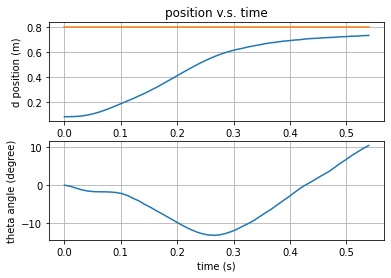

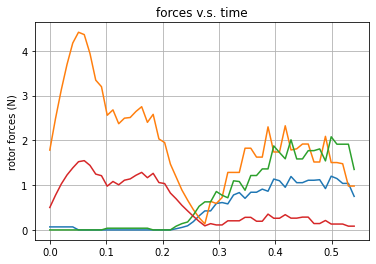

In [ ]:
import matplotlib.pyplot as plt

time_out = dt*state_log.shape[0]

cut = 168
fig1 = plt.figure()
ax11 = fig1.add_subplot(211)
ax11.grid()
ax11.set_ylabel('d position (m)')
ax11.set_title('position v.s. time')
x_position, = ax11.plot(np.linspace(0, time_out, int(time_out//dt))[:cut], data[:cut, 0])
desx_position, = ax11.plot([0.0, time_out],[L, L])


ax13 = fig1.add_subplot(212)
ax13.grid()
ax13.set_ylabel('theta angle (degree)')
ax13.set_xlabel('time (s)')
theta_angle, = ax13.plot(np.linspace(0, time_out, int(time_out//dt))[:cut], data[:cut, 1]*180.0/np.pi)

fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.grid()
ax2.set_ylabel('rotor forces (N)')
ax2.set_title('forces v.s. time')
[ax2.plot(np.linspace(0, time_out, int(time_out//dt))[:cut], f_convolved_8[:cut, i]) for i in range(n)]


In [ ]:
!pip install JSAnimation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for JSAnimation: filename=JSAnimation-0.1-py3-none-any.whl size=11423 sha256=66695f327bbd8381045ede286704a31a4d1b10cfab346fa1494d1debb011b950
  Stored in directory: /root/.cache/pip/wheels/b1/78/80/8fa3ee5db5b384c086dcc7e6c4e4e22caae0687a4f71ba08f8
Successfully built JSAnimation


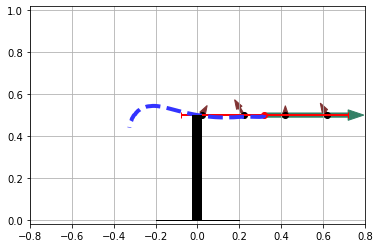

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

fig, ax = plt.subplots()
plt.axis('equal')
sampling = int(1)

dt = 0.05
n = 4
# position of the thrusters from the CoM of the drone
p = np.array([[-3*L/8, 0], [-L/8, 0], [L/8, 0], [3*L/8, 0]]).T

# tilting angles of the propellers
alpha = np.array([-30, 30, -30, 30])*np.pi/180.0

# orientation of the rotors
R = np.zeros([2, 2*n]);
for i in range(n):
    R[:, 2*i:2*i+2] = [[np.cos(alpha[i]), -np.sin(alpha[i])],
                       [np.sin(alpha[i]), np.cos(alpha[i])]]

def animate(t):
    ax.clear()
    plt.xlim([-0.8, 0.8])
    plt.ylim([-0.2, 1.2])
    ax.grid()

    # current position and orientation
    ax.plot(state_log[sampling*t, 0], state_log[sampling*t, 1], 'ro')  # Center of mass
    ax.arrow(state_log[sampling*t, 0], state_log[sampling*t, 1], L/2*np.cos(state_log[sampling*t,2]), 
             L/2*np.sin(state_log[sampling*t,2]), width=0.02, color=[0.2,0.5,0.4], head_width = 0.05)
    # actuators
    # homogeneous vectors and rotations
    pos_p = np.zeros([2, n])
    rot_p = np.zeros([2, n])

    # drone frame left and right ends
    pos_e = np.zeros([2, 2])

    # homogenenous transformation for the current state
    T = np.eye(3)
    T[0:2, 0:2] = np.array([[np.cos(state_log[sampling*t, 2]), -np.sin(state_log[sampling*t, 2])],
                            [np.sin(state_log[sampling*t, 2]), np.cos(state_log[sampling*t, 2])]])
    T[0:2, 2] = state_log[sampling*t, 0:2]
    for i in range(n):
        pos_p[:, i] = T.dot(np.array([p[0, i], p[1, i], 1]))[0:2]
        rot_p[:, i] = T[0:2, 0:2].dot(R[:, 2*i:2*i+2].dot(0.03*np.sqrt(f_convolved_8[sampling*t, i])*np.array([0, 1])))
    
    # drone frame
    pos_e[:, 0] = T.dot(np.array([-L/2, 0, 1]))[0:2]
    pos_e[:, 1] = T.dot(np.array([L/2, 0, 1]))[0:2]

    ax.plot(pos_p[0, :], pos_p[1, :], 'k-o')
    ax.plot([pos_e[0,-1], pos_e[0,0]], [pos_e[1, -1], pos_e[1, 0]], 'r-|', linewidth=2, solid_capstyle="butt")
    
    for i in range(n):
        ax.arrow(pos_p[0, i], pos_p[1, i], rot_p[0, i], rot_p[1, i], width=0.01, color=[0.5,0.2,0.2])
    # Path
    plt.plot(state_log[:, 0], state_log[:, 1], '--', color=[0.2, 0.2, 1.0], linewidth=4)

    # object that is being sawed
    ax.plot([0.0, 0.0], [0.0, h], color=[0.0, 0.0, 0.0], linewidth=10, solid_capstyle="butt")
    ax.plot([-0.2, 0.2], [0.0, 0.0], color=[0.0, 0.0, 0.0], linewidth=1)


time = int(len(state_log)/sampling)
anim = animation.FuncAnimation(fig, animate, frames=time, interval=dt*1000*sampling)

# HTML(anim.to_jshtml())
anim.save("video.mp4")